**SDPA Final Coursework, Part 2**

In [1]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import snscrape.modules.twitter as sntwitter
import re
import yfinance as yf 
from scipy import stats
from scipy.stats import spearmanr
from scipy.stats import pearsonr

**Step 1: Crawl a base real-world dataset for analysis**

The base data of focus for this section of the coursework will be tweet data from the social media platform and digital town square, Twitter. Initially, the plan for the project was to get direct access to the twitter API by applying for an educational account and use the API keys generated by the account to access tweets of my defined specification, but in the end, I was not able to get an account. 

Instead, the external library 'snscraper' has been implemented in order to retrieve tweets of a defined specification. It works analogous to; and parameters are largely defined similarly to the native Twitter documentation, but there is no need for API keys, which has allowed more effort to be put into development, as opposed to API bureaucracy. More information based on ‘snscraper’ and all other external libraries involved in the project can be found in the README.md. file for Part 2 of the assignment.  

In [9]:
df = pd.read_csv('bitcoin _raw_extracted_tweet_data.csv')

display(df)

,Date,ID,Text,Username,Reply count,Retweet count,Like count
0,2022-07-28 23:59:54+00:00,1552806084284407808,@BitPaine The opposite of Bitcoin maxis. \n\nT...,spliffymagoo,0.0,0.0,1.0
1,2022-07-28 23:59:49+00:00,1552806060892852224,"Goldman Sachs, JPMorgan Predict Euro-Area Rece...",bitcoinscoops,0.0,0.0,0.0
2,2022-07-28 23:59:48+00:00,1552806058778923013,THREE WHITE SOLDIERS INBOUND EVERYWHERE. #bitcoin,Bobby_5326,1.0,0.0,15.0
3,2022-07-28 23:59:43+00:00,1552806035378913280,Should @GaryGensler be fired or replaced by a ...,Team_Litecoin,0.0,0.0,0.0
4,2022-07-28 23:59:43+00:00,1552806034473127936,@BitMEX Users who trade our FX contracts can p...,nizeiu1945,0.0,0.0,0.0
...,...,...,...,...,...,...,...
14996,2022-12-24 23:53:10+00:00,1606800178576560128,#Bitcoin Last Price $16840 #BTC 🚀\nWeekly Indi...,LivePriceCrypto,0.0,0.0,1.0
14997,2022-12-24 23:53:00+00:00,1606800137917009920,@CryptoTea_ Better going into Bitcoin than crypto,DenverBTCMAXi,1.0,0.0,2.0
14998,2022-12-24 23:52:59+00:00,1606800135358500865,@zetablockchain @Zeta_Nite @Bitcoin @Galxe gra...,akunenko_dima,0.0,0.0,0.0
14999,2022-12-24 23:52:32+00:00,1606800019151269890,"Bitcoin, Binance Coin, Flow, and Aave Daily Pr...",aliffiq94,0.0,0.0,0.0


After building out the project more and with some more consideration, I found the raw scraped data as insufficient for deep and insightful analysis. Additional API scraping and manipulation of Twitter data has be implemented in the aim of bolstering analysis and potential insights, such additional steps being discussed at length, further into the report. 

**Step 2a: Perform data preparation & cleaning on the generated dataset**

The only section of data that needs cleaning and formatting is the tweet text itself, all other parameters scraped by specification, like date, tweet ID, reply count, retweet count and like count have been scraped to a proper format. In order to remove unnecessary parts and characters from tweet text, a list of regular expressions have been applied to the scraped tweets in an iterative fashion. The pre-defined function below is called and applied to the scraping and the later steps of formatting enriching the data. 

In [77]:
def clean_text(text):
    
    # Removing @mentions. 
    text = re.sub('@[A-Za-z0–9]+', '', text) 
    
    # Removing '#' hash tags. 
    text = re.sub('#', '', text) 
    
    # Removing RTs. 
    text = re.sub('RT[\s]+', '', text) 
    
     # Removing hyperlinks. 
    text = re.sub('https?:\/\/\S+', '', text)
    
    # Remove punctuation. 
    text = re.sub(r'[^\w\s]', '', text)  
    
    # Remove underscores. 
    text = re.sub(r'_', '', text) 
    
    return text 

**Step 2b: Generating daily (numerical) averages of existing columns & further enriching data by adding sentiment, subjectivity columns and price data of the specified asset**

As per the specification of the scraping process, 100 tweets of the given keyword 'bitcoin' have been scraped for the past 150 as of 24/11/2022, this totalling into a raw dataset of 15,000 rows of tweet text data and other auxiliary information stored in other columns over the course of the defined period. Each of the tweets are not so useful in and of themselves. For example, the value of a numeric column (e.g, like count, retweet count) on a particular day is not very useful, that given tweet might have been particularly popular too; it's not a fair reflection of the overall day. To get a true impression of the average of a numeric figure (e.g, like count, retweet count) on a particular day, it would be far more insightful to get a mean of each of these variables over 100 tweets for each day. Therefore, a mean of each numeric value has replaced the 100 values for daily tweets, in the aim of providing a fairer reflection of the general popularity / performance of each tweet. 

The fact that tweet data is text-based data, means there are potentially a great number of insights to be found in the generation of sentiment and subjectivity figures using sentiment analysis. Sentiment and subjectivity scores allow us to interpret tweets; or groups of tweets, and understand the intention behind them, in doing so, we can form an idea of what the public things of a particular thing, in this case the asset 'bitcoin'. The sentiment analyser VADER has been applied to all tweets, an average calculated for all tweets per day (100) and appended to final dataset as a form of enrichment. The same has been done for subjectivity scores, however a different sentiment analyer 'TexBlob' was used for the purpose of discerning sentiment, a VADER does not provide a native measurement of subjectivity. More information on the library 'nltk' and the sentiment analysis tool 'VADER', and all other external libraries involved in the project can be found in the README.md. file for Part 2 of the assignment. In this context, when the term 'mean sentiment' or mean 'subjectivity' is referred to in this assignment, it is in relation to tweet data specifically. 

Finally, BTC data from Yahoo! Finance has also been scraped by calling their API to make potentially interesting comparisons between public sentiment and asset price. More information on the ‘yfinance’ library and all other external libraries involved in the project can be found in the README.md. file for Part 2 of the assignment.  

In [78]:
def tweet_scrape_enrich_aggregate():
    import datetime
    # List of dates tweets are retrieved from. 
    # Could use the dates generated by the tweet scraping, but for nicer looking formatting a the datetime library has been implemented instead. 
    dates = []

    # List of mean values of interest that will be appened to iteratively. 
    # To be concatenated into a single dataframe later. 
    mean_reply_count_list = []
    mean_retweet_count_list = []
    mean_like_count_list = []

    # List for mean sentiment and mean subjectivity to be appended to later. 
    mean_sentiment_list = []
    mean_subjectivity_list = []

    # List of all data scraped from Twitter API. 
    whole_data = []


    # Inputs for key parameters, for this project they have been inputted as the following: bitcoin, 100, 150 . 
    # This is here in case other keywords need to be tested, but static variable are fine too. 
    keyword = (input("Please enter a keyword or phrase to focus your search: "))
    NoOfTweets = int(input("Please enter the number of Tweets you would like to analyse per day: "))
    days = int(input("How many of the last days would you like to analyse?:  "))




    # Loop through the last n days, 150 days for this project. 
    for i in range(days):
      # Calculate the date for the current iteration
        start = datetime.datetime.now() - datetime.timedelta(days=i)
        end = datetime.datetime.now() - datetime.timedelta(days=(i-1 ))
        date_str = start.strftime('%Y-%m-%d')

      # Add the date for current iteration to the list of dates. 
        dates.append(date_str)

    # Reverse list of days to get items in chronological order.      
    dates = dates[::-1]


    # First for loop iterating through list of dates previously generated. 
    for date in dates:
        sentiment_scores = []
        subjectivity_scores = []

        # Empty lists for data of each 100 tweets from each day to be appended to. 
        tweet_list = []
        like_count_list = []
        reply_count_list = []
        retweet_count_list = []

        # test
        # print(date) 

        # Second for loop scraping for 100 tweets iteratively for the date of the outer for loop iteration. 
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{keyword} lang:en until:{date}').get_items()):
            if i>=NoOfTweets: 
                break 
            # Appending all raw data from tweet.     
            whole_data.append([tweet.date, tweet.id, tweet.rawContent, tweet.user.username, tweet.replyCount, tweet.retweetCount, tweet.likeCount])

            # Adding specific data to list of particular description, to be made into mean lists later. 
            tweet_list.append(tweet.rawContent)
            like_count_list.append(tweet.likeCount)
            reply_count_list.append(tweet.replyCount)
            retweet_count_list.append(tweet.retweetCount)
            
            
        for tweet in tweet_list:
            
            # Apply tweet cleaner to tweets before sentiment analysis for more reliable results. 
            tweet = clean_text(tweet)

            analyser = SentimentIntensityAnalyzer()
            # compound sentiment score from the specific tweet stored in the 'scores' variable using VADER. 
            scores = analyser.polarity_scores(tweet)
            
            # TextBlob object created for tweet iteratively. 
            analysis = TextBlob(tweet)
            
            # Compound sentiment and subjectivity scores append to related lists. 
            sentiment_scores.append(scores['compound'])
            subjectivity_scores.append(analysis.sentiment.subjectivity)
        
        # test
        # print(sentiment_scores)
        

            # Calculate the mean of numerical columns, mean sentiment and subjectivity scores for the day. 
        mean_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        mean_sentiment_list.append(mean_sentiment)

        mean_subjectivity = sum(subjectivity_scores) / len(subjectivity_scores)
        mean_subjectivity_list.append(mean_subjectivity)

        mean_like_count = sum(like_count_list) / len(like_count_list)
        mean_like_count_list.append(mean_like_count)

        mean_reply_count = sum(reply_count_list) / len(reply_count_list)
        mean_reply_count_list.append(mean_reply_count)

        mean_retweet_count = sum(retweet_count_list) / len(retweet_count_list)
        mean_retweet_count_list.append(mean_retweet_count)

            
    # Confirmation that tweet scraping and sentiment analysis process has run successfully. 
    print('Scraping and sentiment analysis complete!')
            
            
            
    # Supplementary keyword list for the final dataframe.      
    keyword_list = [f'{keyword}']*days

    # Add mean sentiment, subjectivity, reply count, retweet countm, like count and price information to the data frame for the keyword 'bitcoin'. 
    df1 = pd.Series(keyword_list, name = 'Keyword')
    df2 = pd.Series(dates, name = 'Date')
    df3 = pd.Series(mean_reply_count_list, name = 'Mean reply count')
    df4 = pd.Series(mean_retweet_count_list, name = 'Mean retweet count')
    df5 = pd.Series(mean_like_count_list, name = 'Mean like count')
    df6 = pd.Series(mean_sentiment_list, name = 'Mean sentiment of daily tweets')
    df7 = pd.Series(mean_subjectivity_list, name = 'Mean subjectivity of daily tweets')
    df8 = pd.Series(market_data(days), name = 'Adjusted closing asset price')
    

    df_bitcoin = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], axis = 1)
    print(f'df_{keyword_list[0]} created!')
    
    df_bitcoin.to_csv(f'{keyword}_enriched_data.csv', index = False)
    
    
#     # Aggregate raw data for initial csv file. To be commented out if already generated. 

#     df = pd.DataFrame(whole_data)
#     df.columns = ['Date', 'ID', 'Text', 'Username', 'Reply count', 'Retweet count', 'Like count']
#     df.to_csv(f'{keyword}_raw_extracted_data.csv', index = False)
    
    
    
    
    
    return df_bitcoin

In [79]:
def market_data(days): 
    
    # Set necessary variables, in this case time range of interest and target asset name. 
    start = datetime.datetime(2022, 7, 29)
    end = datetime.datetime(2022, 12, 25)
    symbol = 'BTC-GBP'
    
    # Download specific data from Yahoo! Finance to a dataframe, in this case a 6x150 dataframe. 
    df= yf.download(symbol, start=start, end=end)
    
    # Write to csv if necessary, csv already produced so this is commented out. 
    
    # df.to_csv(f'bitcoin_market_data_29722_251222.csv', index = False)

    # Isolate particular column for adjusted market price at close. 
    df = df['Adj Close'][0:days]
    # Change df to a list, so it can be concatenated with all other lists later. 
    
    btc_price_list = df.values.tolist()
    
    return btc_price_list 

In [81]:
tweet_scrape_enrich_aggregate()

# At the time, price data for the 25th was not available hence the 'NaN' value in the dataframe, this has since be ammended. 

Please enter a keyword or phrase to focus your search:  bitcoin 
Please enter the number of Tweets you would like to analyse per day:  100
How many of the last days would you like to analyse?:   150


Scraping and sentiment analysis complete!
[*********************100%***********************]  1 of 1 completed
df_bitcoin  created!


,Keyword,Date,Mean reply count,Mean retweet count,Mean like count,Mean sentiment of daily tweets,Mean subjectivity of daily tweets,Adjusted closing asset price
0,bitcoin,2022-07-29,0.87,0.77,3.69,0.100597,0.278271,19552.054688
1,bitcoin,2022-07-30,1.42,1.45,7.00,0.197435,0.316977,19430.144531
2,bitcoin,2022-07-31,1.00,0.31,3.05,0.039936,0.288098,19178.634766
3,bitcoin,2022-08-01,0.74,0.36,2.69,0.117555,0.304834,19024.222656
4,bitcoin,2022-08-02,0.80,0.20,2.91,0.117630,0.316604,18922.662109
...,...,...,...,...,...,...,...,...
145,bitcoin,2022-12-21,0.25,0.02,1.13,0.052238,0.270928,13925.944336
146,bitcoin,2022-12-22,0.94,0.75,3.75,0.162072,0.341690,13981.368164
147,bitcoin,2022-12-23,1.81,1.62,12.79,0.224089,0.351902,13935.910156
148,bitcoin,2022-12-24,2.56,4.58,15.37,-0.002429,0.327548,13978.060547


The enriched dataset above provides the opportunity for far more details and wide-ranging analysis, through the addition of figures from appling sentiment anlysis using VADER and TextBlob on the text of each of tweet, and BTC (Bitcoin) price data from the Yahoo! Finance API. Averages of numeric figures native to Twitter have also been computed to give a better impression of user interaction and tweet performance throughout a given day. 

**Exploratory analysis, computing summary statistics and generating preliminary visualisations**

Summary statistics for all numeric columns of the enriched and formatted data is as follows - 

In [118]:
# Read formatted and enriched data to a dataframe for analysis. 
df = pd.read_csv('bitcoin _enriched_data.csv')

df = df.select_dtypes(include=['int', 'float'])
# Iterate over the columns of the dataframe.
for column in df.columns:
    # Calculate the mean, standard deviation, minimum, maximum and sum values. 
    if column in non_numeric_list: 
        pass 
    
    mean = df[column].mean()
    std = df[column].std()
    min_val = df[column].min()
    max_val = df[column].max()
    sum_val = df[column].sum()

    # Calculate the 25th, 50th, and 75th percentile values.
    q25 = df[column].quantile(0.25)
    q50 = df[column].quantile(0.50)
    q75 = df[column].quantile(0.75)

    # Print the summary statistics for the column.
    print(f'Column: {column}')
    print(f'Mean: {mean}')
    print(f'Std Dev: {std}')
    print(f'Min: {min_val}')
    print(f'Max: {max_val}')
    print(f'Sum: {sum_val}')
    print(f'25th Percentile: {q25}')
    print(f'50th Percentile: {q50}')
    print(f'75th Percentile: {q75}')
    print('  ')


Column: Mean reply count
Mean: 1.5564
Std Dev: 2.20471407085549
Min: 0.2
Max: 20.72
Sum: 233.45999999999998
25th Percentile: 0.6174999999999999
50th Percentile: 0.905
75th Percentile: 1.4849999999999999
  
Column: Mean retweet count
Mean: 1.0541333333333331
Std Dev: 2.1838852105766433
Min: 0.02
Max: 21.73
Sum: 158.12
25th Percentile: 0.21
50th Percentile: 0.47
75th Percentile: 0.9675
  
Column: Mean like count
Mean: 5.731266666666666
Std Dev: 7.803284482854508
Min: 0.72
Max: 77.14
Sum: 859.6899999999998
25th Percentile: 2.0999999999999996
50th Percentile: 3.3
75th Percentile: 6.7225
  
Column: Mean sentiment of daily tweets
Mean: 0.09339448666666664
Std Dev: 0.04723149202032753
Min: -0.010232
Max: 0.224089
Sum: 14.009173
25th Percentile: 0.055648750000000004
50th Percentile: 0.09420400000000001
75th Percentile: 0.12391450000000001
  
Column: Mean subjectivity of daily tweets
Mean: 0.31655903475333325
Std Dev: 0.033537294486504166
Min: 0.224476948
Max: 0.409814087
Sum: 47.483855213
25th

<AxesSubplot:>

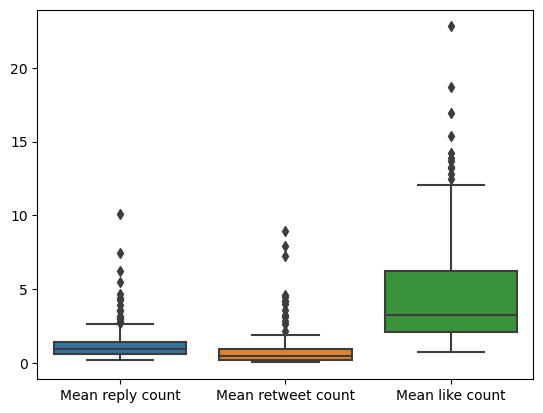

In [2]:
# Visualising summary statistics 
# Data in columns adjusted / removed where seen fit to better show the distribution. 
columns = ['Mean reply count','Mean retweet count','Mean like count']
df = pd.read_csv('bitcoin _enriched_data_outlier_adjusted.csv', usecols = columns)

sns.boxplot(data = df)

<AxesSubplot:>

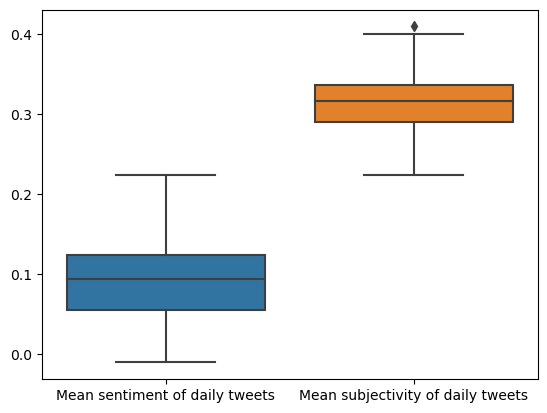

In [5]:
# Visualising summary statistics 

columns = ['Mean sentiment of daily tweets', 'Mean subjectivity of daily tweets']
df = pd.read_csv('bitcoin _enriched_data.csv', usecols = columns)

sns.boxplot(data = df)

<AxesSubplot:>

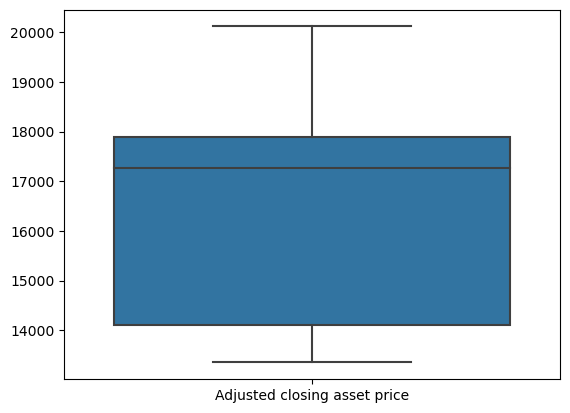

In [127]:
# Visualising summary statistics 

columns = ['Adjusted closing asset price']
df = pd.read_csv('bitcoin _enriched_data.csv', usecols = columns)

sns.boxplot(data = df)

**Step 4: Asking questions of the enriched, formatted data**

The data of focus on at this stage of the assignment will of course be the enriched data that accounts the for means of numerical figures from the raw tweet data produced using 'snscraper' and other columns of interested generated using other external libraries, like sentiment and subjectivity scores generated by VADER and TextBlob respectively and price data retrived from the Yahoo! Finance API. 

In [87]:
def pearsonr_tester(v1, v2): 
    
    print('   ')
    pearsonr_result = pearsonr(v1, v2)
    print(pearsonr_result)

    if  (pearsonr_result[1])< 0.05: 

        print('Reject the null hypothesis that is there no statistically significant correlation between the two variables.')
        print(f'The statistically affirmed correlation between the two variables has been found to be {pearsonr_result[0]}.')

    else: 

        print('We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.')
        
    print('  ')

In [88]:
def spearmanr_tester(v1, v2): 
    
    print('   ')
    spearmanr_result = spearmanr(v1, v2)
    print(spearmanr_result)

    if (spearmanr_result[1] < 0.05): 

        print('Reject the null hypothesis that is there no statistically significant correlation between the two variables.')
        print(f'The statistically affirmed correlation between the two variables has been found to be {spearmanr_result[0]}.')

    else: 

        print('We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.')
        
    print('  ')

In [57]:
def normality_tester(column_name):

    print("Using Shapiro-Wilk test to test the null hypothesis " +
          "that the data was drawn from a normal distribution:")

    df = pd.read_csv('bitcoin _enriched_data.csv')
    
    statistic, pvalue = stats.shapiro(df[column_name])
    if pvalue < 0.05:
        print("Condition " + "{:}".format(column_name) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("Condition " + "{:}".format(column_name) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")
    
    print('   ')

**Question 1a: What is the relationship between mean like count and the averages of the other two performance metrics native to Twitter - reply and retweet count?**

**Question 1b: And if mean like count can be thought of as a generalised measure of a tweet's 'success' on the platform, then do more positively or negatively polarised tweets perform better (sentiment)? Do tweets relating to subjective or objective statements perform better (subjectivity)?**

- Are these correlations statistically significant? 

- If so, how can these results be interpreted? And what might it suggest about user behaviour?

In [82]:
# Question 1a:

# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
v1 = df_bitcoin['Mean like count']
v2 = df_bitcoin['Mean reply count']
v3 = df_bitcoin['Mean retweet count']

# Testing the normality for each variable to determine whether to use a parametric or non-parametric test. 
normality_tester('Mean like count')
normality_tester('Mean reply count')
normality_tester('Mean retweet count')

Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean like count. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean reply count. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean retweet count. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   


In [89]:
# All of the three variables native to Twitter have been found to be non-parametric in nature. 
# Therefore a non-parametric correlation test must be implemented, the Spearman r test fits this specification. 

# Calculating the correlation between the daily mean like count and daily mean reply count of the keyword 'bitcoin' over 150 days. 
print('Testing the correlation between the daily mean like count and daily mean reply count.')
# Implementing correlation tester for statistical significance. 
spearmanr_tester(v1, v2)     

# Calculating the correlation between the daily mean like count and daily mean retweet count of the keyword 'bitcoin' over 150 days. 
print('Testing the correlation between the daily mean like count and daily mean retweet count.')
spearmanr_tester(v1, v3)


Testing the correlation between the daily mean like count and daily mean reply count.
   
SpearmanrResult(correlation=0.7452903243783007, pvalue=7.709634595987687e-28)
Reject the null hypothesis that is there no statistically significant correlation between the two variables.
The statistically affirmed correlation between the two variables has been found to be 0.7452903243783007.
  
Testing the correlation between the daily mean like count and daily mean retweet count.
   
SpearmanrResult(correlation=0.8870008188994254, pvalue=1.5924904574070564e-51)
Reject the null hypothesis that is there no statistically significant correlation between the two variables.
The statistically affirmed correlation between the two variables has been found to be 0.8870008188994254.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Absolute number of metric')]

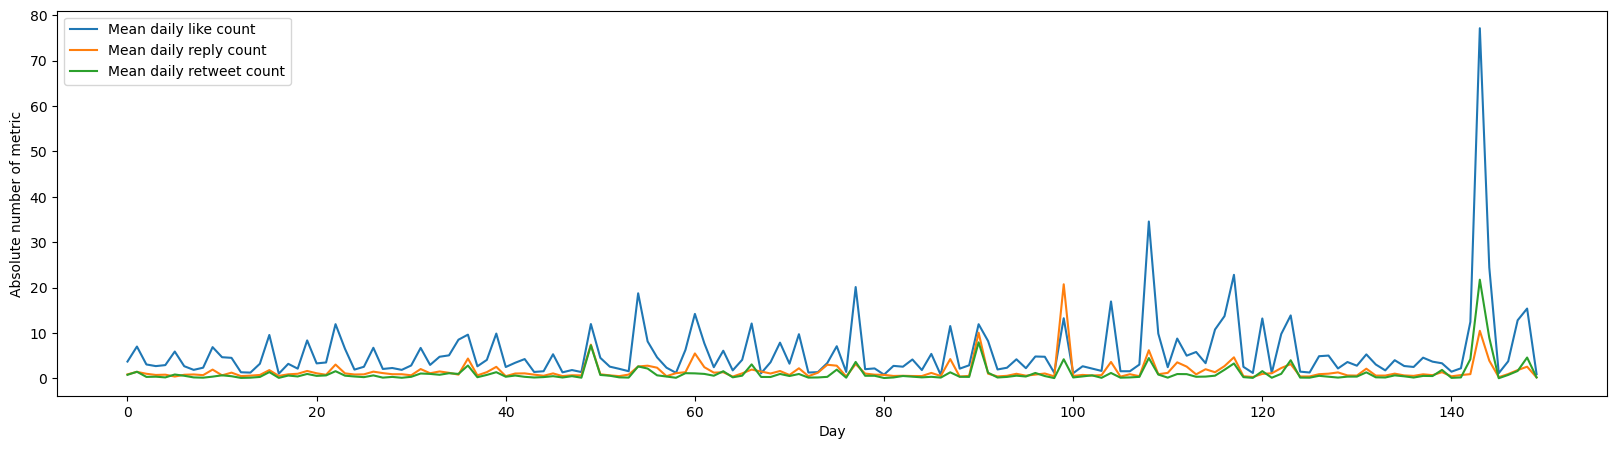

In [94]:
# Plotting line graph to visualise correlation, (transformations applied where necessary). 

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean like count', data = df_bitcoin, label = 'Mean daily like count ').set(xlabel = 'Day', ylabel = 'Absolute number of metric')
sns.lineplot(x = df_bitcoin.index, y = 'Mean reply count', data = df_bitcoin, label = 'Mean daily reply count').set(xlabel = 'Day', ylabel = 'Absolute number of metrice')
sns.lineplot(x = df_bitcoin.index, y = 'Mean retweet count', data = df_bitcoin, label = 'Mean daily retweet count').set(xlabel = 'Day', ylabel = 'Absolute number of metric')

For the **analysis regarding part 1a**, it has been shown that there is a statisitcally significant relationship between mean like count, and mean reply and retweet count. To be specific, corrlelations of 0.745 (3.d.p) and 0.887 (3.d.p) respectively. This provides insight to user behaviour as it shows that generally speaking, the more likes a given tweet has, the more replies and retweets it will have, but also in a more micro sense, if a given user likes a certain post, they are more likely to reply and much more likely to retweet. 

The presented data is aggregated and therefore does not specifically show that the liking of a tweet consequently affects the probability of a specific user replying and/or retweeting a tweet, however it seems counterintuitive and improbable that a give user would retweet and reply to a post without liking it first. Supporting the series of action as something similar to as follows - 1.) Like a tweet, 2.) likely retweet it, 3.) possibly reply to it. Though this very likely is the case for retweets because of how high the correlation coefficient is between likes and retweets, the lower correlation coefficent of replies suggests a potentially contrary case to consider: a user disagrees with the said post and therefore replies (likely with something negative) and does not like the post, which could be a contributing factor for as to why the correlation between likes and replies is weaker. Replying also of course  takes much more effort, as opposed to simply pressing a like or retweet button, meaning the threshold of 'appreciation' a user would have to reach that would justify the particular course of action is higher, also likely contributing to the lower correlation coefficient. Put simply, this discrepancy can be put down to how likes and retweets can be thought of a purely positive metric, while replying to a tweet can abe both supportive and critical while also taking more time and effort (barrier to entry in a way) to perform. It is important to understand that these results are not representive of tweets in general, but rather a very small section of tweets related to the keyword 'bitcoin', the bitcoin maximalist community may have comparatively higher rates of engagement when compared to the rest of Twitter. 

In summary, for the keyword 'bitcoin' it has been shown that if a given user likes a tweet, they are very likely to retweet and somewhat likely to reply to it. 

In [91]:
# Question 1b:

# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning variables to later apply Pearson r correlation test to. 
v1 = df_bitcoin['Mean like count']
v2 = df_bitcoin['Mean sentiment of daily tweets']
v3 = df_bitcoin['Mean subjectivity of daily tweets']

# Testing the normality for each variable to determine whether to use a parametric or non-parametric test. 
# Mean like count is already known to be non-parametric. 
normality_tester('Mean sentiment of daily tweets')
normality_tester('Mean subjectivity of daily tweets')

Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean sentiment of daily tweets. We cannot reject the null hypothesis (p=0.40). Therefore, data is normally distributed.
   
Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Mean subjectivity of daily tweets. We cannot reject the null hypothesis (p=0.24). Therefore, data is normally distributed.
   


In [92]:
# Mean like count is known to be non-parametric, but mean sentiment of daily tweets and subjectivty data of the same description have been found to be parametric. 
# Despite the last two variables being parametric, because mean like count is non-pareametric, a non-parametric correlation test must be implemented. 
# The Spearman r test fits this specification. 

print('Testing the correlation between the daily mean like count and mean sentiment of daily tweets.')
spearmanr_tester(v1, v2)

# Calculating the correlation between the daily mean like count and mean subjectivity of daily tweets. 
print('Testing the correlation between the daily mean like count and mean subjectivity of daily tweets.')
spearmanr_tester(v1, v3)

Testing the correlation between the daily mean like count and mean sentiment of daily tweets.
   
SpearmanrResult(correlation=0.05383085718914084, pvalue=0.512950752381278)
We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.
  
Testing the correlation between the daily mean like count and mean subjectivity of daily tweets.
   
SpearmanrResult(correlation=0.04812561837812449, pvalue=0.5586658443725971)
We cannot reject the null hypothesis, therefore there is no statistically significant correlation between the two variables.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, 'Absolute number of metric')]

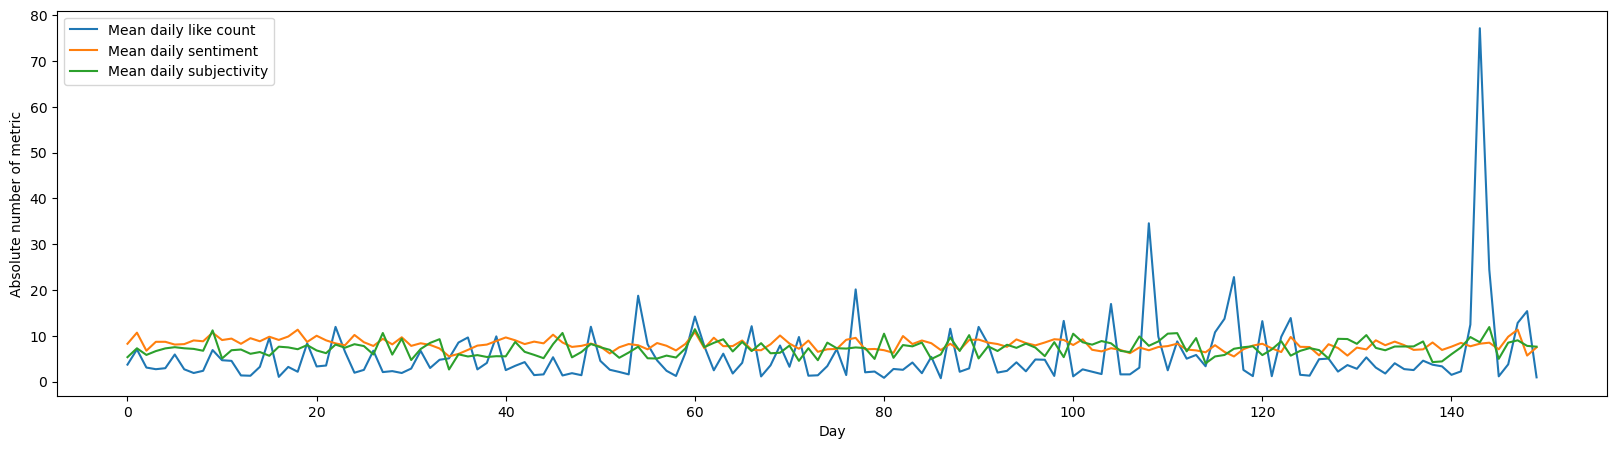

In [100]:
# Mean sentiment and subjectivity scaled in order to view any correlation more closely when visualised. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] * 25
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] + df_bitcoin['Mean like count'].mean()
df_bitcoin['Mean subjectivity of daily tweets'] = df_bitcoin['Mean subjectivity of daily tweets'] * 50
df_bitcoin['Mean subjectivity of daily tweets'] = df_bitcoin['Mean subjectivity of daily tweets'] - (df_bitcoin['Mean like count'].mean())* 1.5

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean like count', data = df_bitcoin, label = 'Mean daily like count ').set(xlabel = 'Day', ylabel = 'Absolute number of metric')
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Mean daily sentiment').set(xlabel = 'Day', ylabel = 'Absolute number of metrice')
sns.lineplot(x = df_bitcoin.index, y = 'Mean subjectivity of daily tweets', data = df_bitcoin, label = 'Mean daily subjectivity').set(xlabel = 'Day', ylabel = 'Absolute number of metric')

For the **analysis regarding part 1b**, it has been shown that there is no statistically significant relationship between mean like count and mean sentiment of daily tweets or mean subjectivity of daily tweets. 

This provides insight into user preferences as it shows the likelyhood of a user on Twitter liking a given tweet is not affected very much at all by how apparently positive or negative it is in nature or how much it varies between being more subjecive or objective. It could be easily assumed that more extremely positive or negative tweets; and therefore more polarising, tweets would stand out, garner more views and therefore more likes, but this has shown not to be true. Similarly, the extent to which a tweet is more subjective or opinion based than objective or fact based does not seem to have a significant effect on the relative 'performance' of a tweet. 

Again, it is important to stress that while it may be the case that users when confronted with a tweets containing the keyword 'bitcoin' are not significantly affected by how positive, negative, subjective or objective the said tweet is, results may differ greatly when tweets related to more polarising keywords like 'politics' are analysed. This perhaps says much more about the blockchain and Bitcoin community on Twitter, than the platform itself, as it is harder to form a general impression without the context of more keywords across a wide range of topics. 

**Question 2: What is the relationship between the daily mean sentiment of tweets with the keyword 'bitcoin' and mean subjectivity of the same description?**

- Is this correlation statistically significant? 

- How can this be interpreted? And what might it suggest about the nature of tweets? 

In [102]:
# Question 2:

# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
# Both variables are known to be parametric in naturem, so tests for normality are not necessary. 
v1 = df_bitcoin['Mean sentiment of daily tweets']
v2 = df_bitcoin['Mean subjectivity of daily tweets']

# Implementing correlation tester for statistical significance. 
print('Testing the correlation between mean sentiment of daily tweets and mean subjectivity of the same description.')
pearsonr_tester(v1, v2)

Testing the correlation between mean sentiment of daily tweets and mean subjectivity of the same description.
   
PearsonRResult(statistic=0.18766752307468548, pvalue=0.021465645926449436)
Reject the null hypothesis that is there no statistically significant correlation between the two variables.
The statistically affirmed correlation between the two variables has been found to be 0.18766752307468548.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, '')]

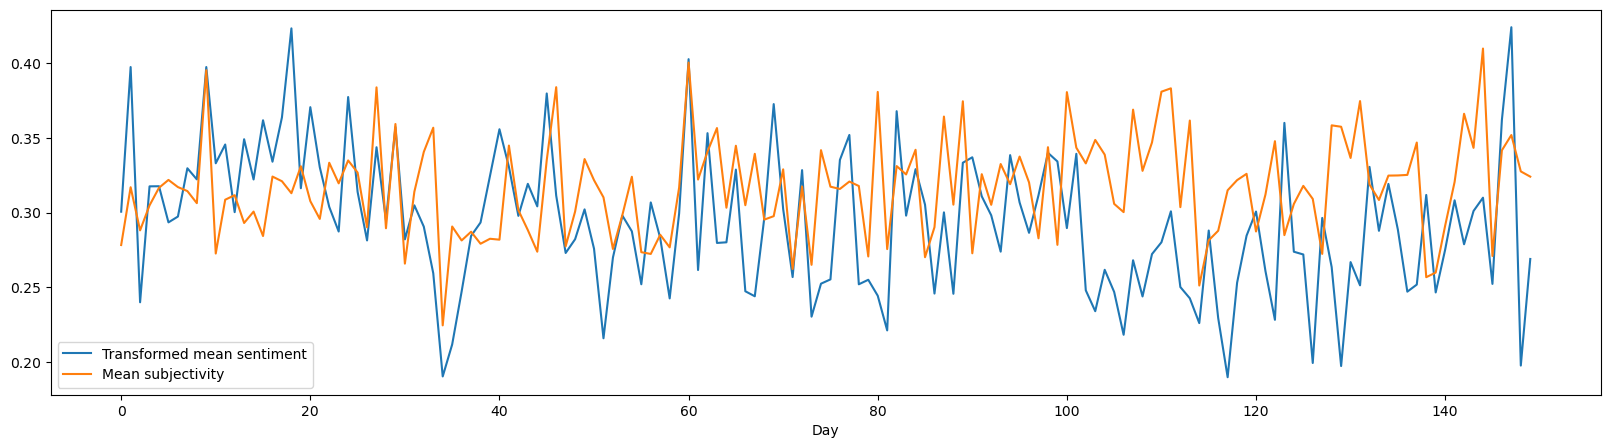

In [103]:
# Mean sentiment has to be scaled a little bit to make the correlation between sentiment and subjectivity clear. 
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] + 0.2

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Transformed mean sentiment').set(xlabel = 'Day', ylabel = None)
sns.lineplot(x = df_bitcoin.index, y = 'Mean subjectivity of daily tweets', data = df_bitcoin, label = 'Mean subjectivity').set(xlabel = 'Day', ylabel = None)

**Question 3: What is the relationship between the daily mean sentiment of tweets with the keyword 'bitcoin' and the adjusted closing price of bitcoin over the last 150 days?**

- And if there is a correlation between the two variables, is it statistically significant? 

- How can this resulting correlation be interpreted? What might it suggest? 

In [104]:
# Question 3:
# Reading the enriched and formatted dataframe necessary for analysis. 
df_bitcoin = pd.read_csv('bitcoin _enriched_data.csv')

# Assigning varibales to later apply Pearson r correlation test to. 
v1 = df_bitcoin['Mean sentiment of daily tweets']
v2 = df_bitcoin['Adjusted closing asset price']

normality_tester('Adjusted closing asset price')

Using Shapiro-Wilk test to test the null hypothesis that the data was drawn from a normal distribution:
Condition Adjusted closing asset price. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
   


In [105]:
# Implementing correlation tester for statistical significance. 
print('Testing the correlation between the mean sentiment of daily tweets and the adjusted closing price of Bitcoin, BTC.')
spearmanr_tester(v1, v2)

Testing the correlation between the mean sentiment of daily tweets and the adjusted closing price of Bitcoin, BTC.
   
SpearmanrResult(correlation=0.465786034934886, pvalue=1.8973477451302384e-09)
Reject the null hypothesis that is there no statistically significant correlation between the two variables.
The statistically affirmed correlation between the two variables has been found to be 0.465786034934886.
  


[Text(0.5, 0, 'Day'), Text(0, 0.5, '')]

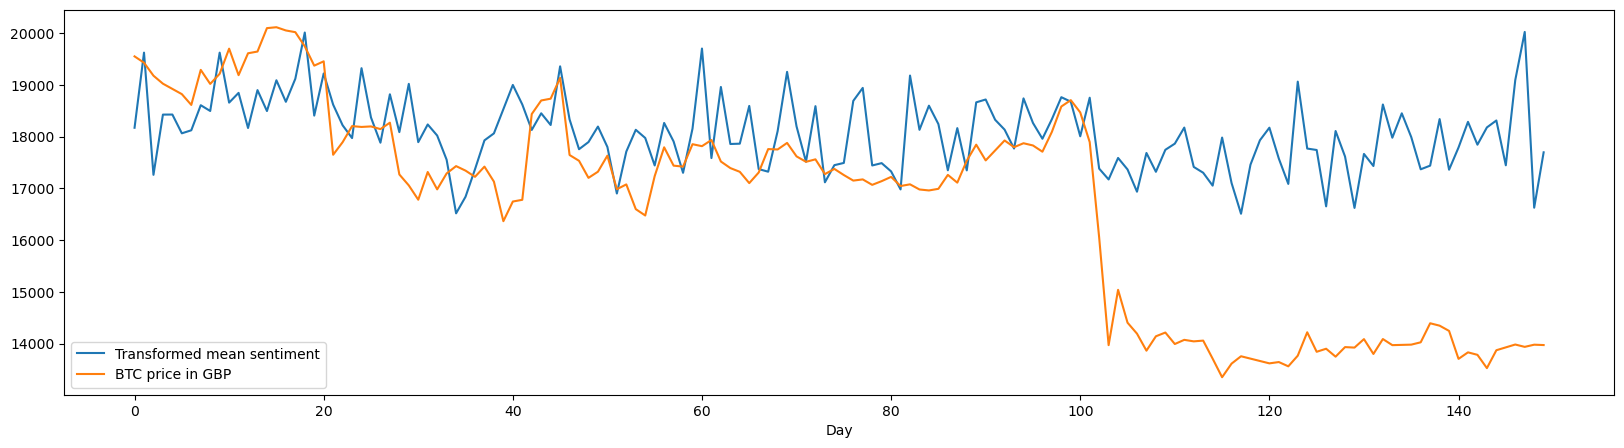

In [106]:
# Mean sentiment has to be transformed to make any potential clear, as the price of bitcoin is many orders of magnitude larger than mean sentiment. 
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets']*15000
df_bitcoin['Mean sentiment of daily tweets'] = df_bitcoin['Mean sentiment of daily tweets'] + df_bitcoin['Adjusted closing asset price'].mean()

plt.figure(figsize=(20, 5))
sns.lineplot(x = df_bitcoin.index, y = 'Mean sentiment of daily tweets', data = df_bitcoin, label = 'Transformed mean sentiment').set(xlabel = 'Day', ylabel = None)
sns.lineplot(x = df_bitcoin.index, y = 'Adjusted closing asset price', data = df_bitcoin, label = 'BTC price in GBP').set(xlabel = 'Day', ylabel = None)
